In [48]:
!pip install scikit-learn
!pip install pyspark
!pip install matplotlib

In [49]:
# Importing libraries

from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt

In [50]:
# Get preprocessed data

spark = SparkSession.builder.master("local[1]").appName("SparkByExamples.com").getOrCreate()
df = spark.read.option("inferSchema", "true").csv("../Preprocessing/NYC Taxi Duration Preprocessed/*.csv", header=True)
df.printSchema()

root
 |-- id: integer (nullable = true)
 |-- vendor_id: integer (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- dropoff_latitude: double (nullable = true)
 |-- store_and_fwd_flag: integer (nullable = true)
 |-- trip_duration: integer (nullable = true)
 |-- distance: double (nullable = true)
 |-- week_day: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- quarter_of_year: integer (nullable = true)
 |-- hour: integer (nullable = true)



In [51]:
df.show()

+-------+---------+---------------+----------------+---------------+-----------------+----------------+------------------+-------------+---------+--------+----+-----+---------------+----+
|     id|vendor_id|passenger_count|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|store_and_fwd_flag|trip_duration| distance|week_day|year|month|quarter_of_year|hour|
+-------+---------+---------------+----------------+---------------+-----------------+----------------+------------------+-------------+---------+--------+----+-----+---------------+----+
|2875421|        2|              1|      -73.982155|      40.767937|        -73.96463|       40.765602|                 0|          455|2.4444735|     Mon|2016|    3|              1|  17|
|2377394|        1|              1|      -73.980415|      40.738564|        -73.99948|        40.73115|                 0|          663|2.6599078|     Sun|2016|    6|              2|   0|
|3858529|        2|              1|       -73.97903|       4

# KMeans with sklearn

In [52]:
week_day_col = StringIndexer(inputCol = 'week_day', outputCol = 'week_day_index')
df = week_day_col.fit(df).transform(df)
df.show(5)

+-------+---------+---------------+----------------+---------------+-----------------+----------------+------------------+-------------+---------+--------+----+-----+---------------+----+--------------+
|     id|vendor_id|passenger_count|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|store_and_fwd_flag|trip_duration| distance|week_day|year|month|quarter_of_year|hour|week_day_index|
+-------+---------+---------------+----------------+---------------+-----------------+----------------+------------------+-------------+---------+--------+----+-----+---------------+----+--------------+
|2875421|        2|              1|      -73.982155|      40.767937|        -73.96463|       40.765602|                 0|          455|2.4444735|     Mon|2016|    3|              1|  17|           6.0|
|2377394|        1|              1|      -73.980415|      40.738564|        -73.99948|        40.73115|                 0|          663|2.6599078|     Sun|2016|    6|              2|   0| 

## Elbow Method

In [53]:
input_col = df.drop(df["trip_duration"])
input_col = input_col.drop(df["week_day"])
input_col = input_col.toPandas()

In [54]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=0, n_init=10)
    kmeans.fit(input_col)
    wcss.append(kmeans.inertia_)
    
    print("k: ", str(i), ' Done')

k:  1  Done
k:  2  Done
k:  3  Done
k:  4  Done
k:  5  Done
k:  6  Done
k:  7  Done
k:  8  Done
k:  9  Done
k:  10  Done


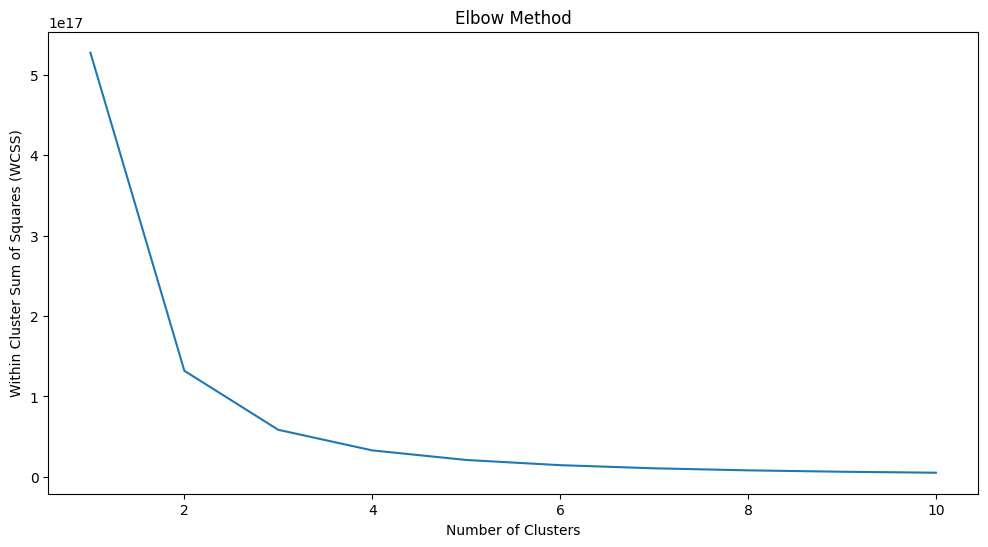

In [55]:
plt.figure(figsize=(12, 6), dpi=100)

plt.plot(range(1, 11), wcss)

plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Within Cluster Sum of Squares (WCSS)')

plt.show()

In [56]:
#Using StandarnScaler to set all the columns in the dataframe to the same scale.
std_scaler = StandardScaler()
X = std_scaler.fit_transform(input_col)

X

array([[ 0.75883482,  0.93233136, -0.50869035, ..., -1.01385619,
         0.52737617,  1.56261772],
       [ 0.32718395, -1.07258003, -0.50869035, ...,  0.98633318,
        -2.05736748,  0.55772729],
       [ 1.61091598,  0.93233136, -0.50869035, ..., -1.01385619,
        -0.3848863 ,  1.06017251],
       ...,
       [ 1.21958241,  0.93233136,  0.25369541, ..., -1.01385619,
        -1.90532373,  0.55772729],
       [ 1.67441809, -1.07258003, -0.50869035, ...,  0.98633318,
         0.37533242, -0.44716313],
       [-1.4975255 ,  0.93233136,  3.30323845, ...,  0.98633318,
         1.13555114, -0.44716313]])

In [58]:
# We can see that the graph above levels off at around k=4. So we will use that as our number of clusters.
# Now we will create a k-means clustering model that uses 4 clusters (k=4)

kmeans_cluster = KMeans(n_clusters = 4, init = 'k-means++', random_state = 0)
clusters_prediction = kmeans_cluster.fit_predict(X)

/Users/adarshdudhat/Desktop/University Of Calgary/Classes/FALL - 2022/SENG - 550/Project/seng550final/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


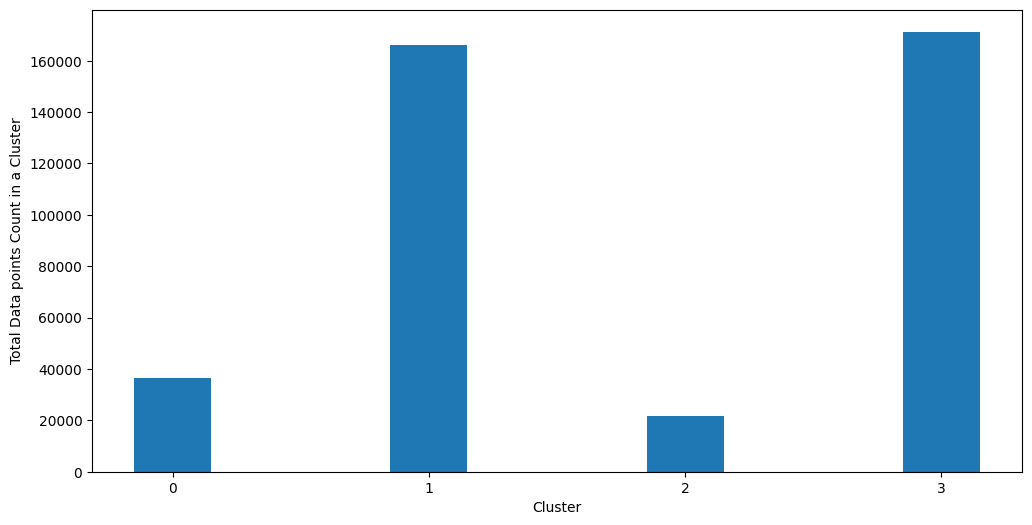

In [63]:
# Graph out the size of each cluster.
input_col['cluster'] = clusters_prediction
cluster_counts = input_col.groupby(['cluster'])['cluster'].count()

plt.figure(figsize=(12, 6), dpi=100)

plt.bar(['0', '1', '2', '3'], cluster_counts.values, width = 0.3)

plt.xlabel('Cluster')
plt.ylabel('Total Data points Count in a Cluster')

plt.show()

In [65]:
for i in range(len(cluster_counts.values)):
    print("Cluster: ", i, " Total Data Points: ", cluster_counts.values[i])

Cluster:  0  Total Data Points:  36557
Cluster:  1  Total Data Points:  166289
Cluster:  2  Total Data Points:  21849
Cluster:  3  Total Data Points:  171302
